## 模型训练

In [3]:
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats import chi2
import statsmodels.discrete.discrete_model as dm_

import copy
import joblib
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets.samples_generator import make_blobs
from sklearn.linear_model.logistic import LogisticRegression

from scikitplot.metrics import plot_ks_statistic, plot_lift_curve
from scikitplot.helpers import binary_ks_curve
import shap

%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 准备数据

In [4]:
data_path = f"{os.path.abspath('.')}/home-credit-default-risk/"

train_final = joblib.load(data_path + 'train_woe.pkl')
test_woe = joblib.load(data_path + 'test_woe.pkl')

In [5]:
train_final
test_final = test_woe[train_final.columns]

In [6]:
cols = list(train_final.columns)
cols.remove('TARGET')
cols.remove('SK_ID_CURR')

In [26]:
train, test = train_test_split(train_final, test_size=0.3)

## 模型训练

In [27]:
model = GradientBoostingClassifier()
model.fit(train[cols], train['TARGET'])

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

## 模型评估

In [30]:
yprob = model.predict_proba(test[cols])
ypred = model.predict(test[cols])

In [31]:
print('测试集准确率：{:.2%}'.format(accuracy_score(test['TARGET'], ypred)))
print('测试集精度：{:.2%}'.format(precision_score(test['TARGET'], ypred)))
print('测试集召回率：{:.2%}'.format(recall_score(test['TARGET'], ypred)))
print('测试集AUC：{:.2%}'.format(roc_auc_score(test['TARGET'], yprob[:, 1])))

测试集准确率：91.79%
测试集精度：51.39%
测试集召回率：1.39%
测试集AUC：76.87%


In [32]:
def plot_roc(ytrue, yprob):
    fpr, tpr, thresholds = roc_curve(ytrue, yprob, pos_label=1)
    auc_score = auc(fpr, tpr)
    w = tpr - fpr
    ks_score = w.max()
    ks_x = fpr[w.argmax()]
    ks_y = tpr[w.argmax()]
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label='AUC=%.5f' % auc_score)
    ax.set_title('Receiver Operating Characteristic')
    ax.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    ax.plot([ks_x, ks_x], [ks_x, ks_y], '--', color='red')
    ax.text(ks_x, (ks_x + ks_y) / 2, '  KS=%.5f' % ks_score)
    ax.legend()
    fig.show()

In [37]:
def plot_ks(ytrue, yprob):
    fpr, tpr, thresholds = roc_curve(ytrue, yprob, pos_label=1)
    w = tpr - fpr
    thresholds[0] -= 1
    
    df = pd.DataFrame({'ytrue': test['TARGET'], 'yscore': yprob})

    c0 = len(df[df['ytrue']==0])
    c1 = len(df[df['ytrue']==1])
    cnt_good = [len(df[(df['yscore'] < thr) & (df['ytrue']==0)])/c0 for thr in thresholds]
    cnt_bad = [len(df[(df['yscore'] < thr) & (df['ytrue']==1)])/c1 for thr in thresholds]

    plt.plot(thresholds, w, '-b', label='ks')
    plt.plot(thresholds, cnt_good, '-g', label='good')
    plt.plot(thresholds, cnt_bad, '-r', label='bad')

    plt.show()

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


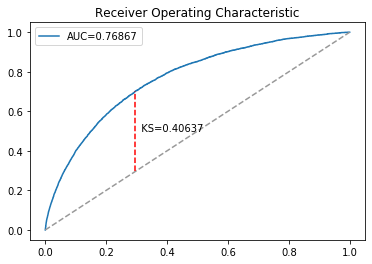

In [34]:
plot_roc(test['TARGET'], yprob[:, 1])

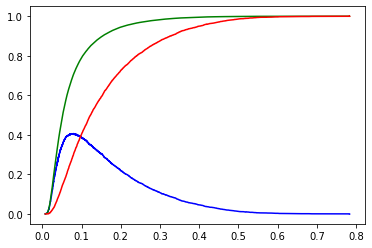

In [38]:
plot_ks(test['TARGET'], yprob[:, 1])

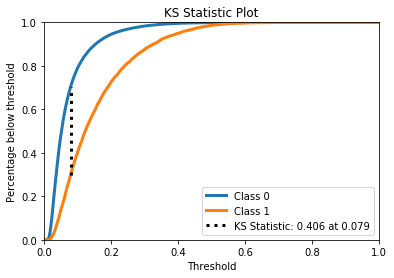

In [40]:
plot_ks_statistic(test['TARGET'].values, yprob)

## 模型融合

In [41]:
clfs = [AdaBoostClassifier(),
        RandomForestClassifier(n_estimators=50, n_jobs=-1, criterion='entropy'),
        LogisticRegression(C=0.01),
        ExtraTreesClassifier(n_estimators=50, n_jobs=-1, criterion='entropy'),
        GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=50)]

In [42]:
xtrain, xtest, ytrain, ytest = train_test_split(train_final[cols].values, train_final['TARGET'].values, test_size=0.3)

In [43]:
btrain = np.zeros((xtrain.shape[0], len(clfs)))
btest = np.zeros((xtest.shape[0], len(clfs)))

In [44]:
skf = list(StratifiedKFold(5).split(xtrain, ytrain))

In [45]:
for j, clf in enumerate(clfs):
    btest_j = np.zeros((xtest.shape[0], len(skf)))
    
    for i, (itrain, itest) in enumerate(skf):
        xtrain_i, ytrain_i, xtest_i, ytest_i = xtrain[itrain], ytrain[itrain], xtrain[itest], ytrain[itest]
        
        clf.fit(xtrain_i, ytrain_i)
        yprob = clf.predict_proba(xtest_i)[:, 1]
        
        btrain[itest, j] = yprob
        btest_j[:, i] = clf.predict_proba(xtest)[:, 1]
        
    btest[:, j] = btest_j.mean(1)
    print("使用第" + str(j) + "个模型的：" + "AUC: %f" % roc_auc_score(ytest, btest[:, j]))

使用第0个模型的：AUC: 0.757485
使用第1个模型的：AUC: 0.750754
使用第2个模型的：AUC: 0.755642
使用第3个模型的：AUC: 0.748411
使用第4个模型的：AUC: 0.760980


In [46]:
clf = GradientBoostingClassifier(learning_rate=0.02, subsample=0.5, max_depth=6, n_estimators=30)
clf.fit(btrain, ytrain)
yprob_stack = clf.predict_proba(btest)

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


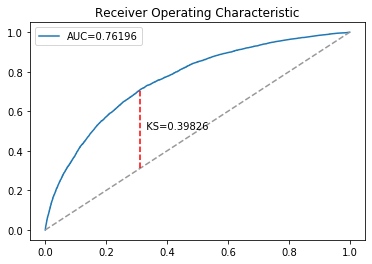

In [47]:
plot_roc(ytest, yprob_stack[:, 1])

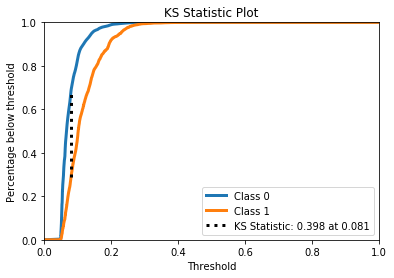

In [48]:
plot_ks_statistic(ytest, yprob_stack)

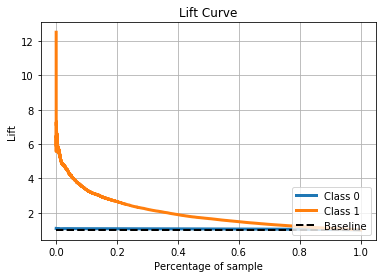

In [49]:
plot_lift_curve(ytest, yprob_stack)

## Shap分析

In [50]:
explainer = shap.TreeExplainer(model)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
The sklearn.ensemble.gradient_boosting module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.


In [52]:
shap_values = explainer.shap_values(train[cols], train['TARGET'])

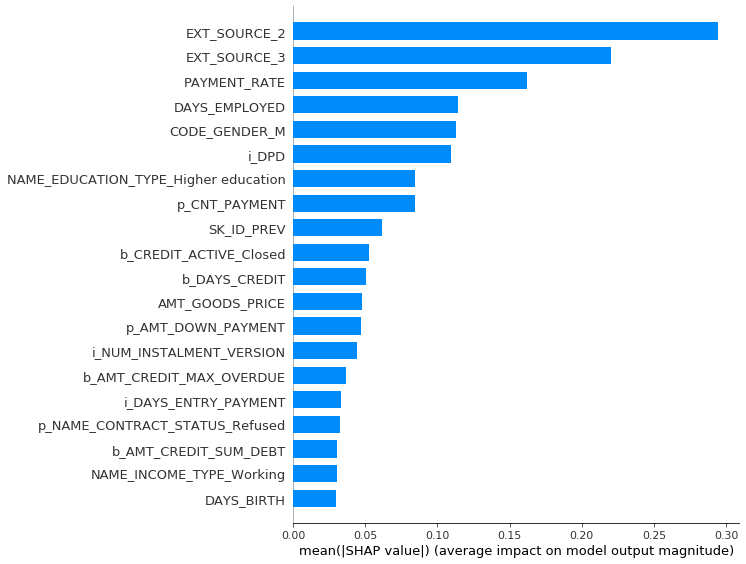

In [53]:
shap.summary_plot(shap_values, train[cols], feature_names=cols, plot_type="bar", max_display=20)

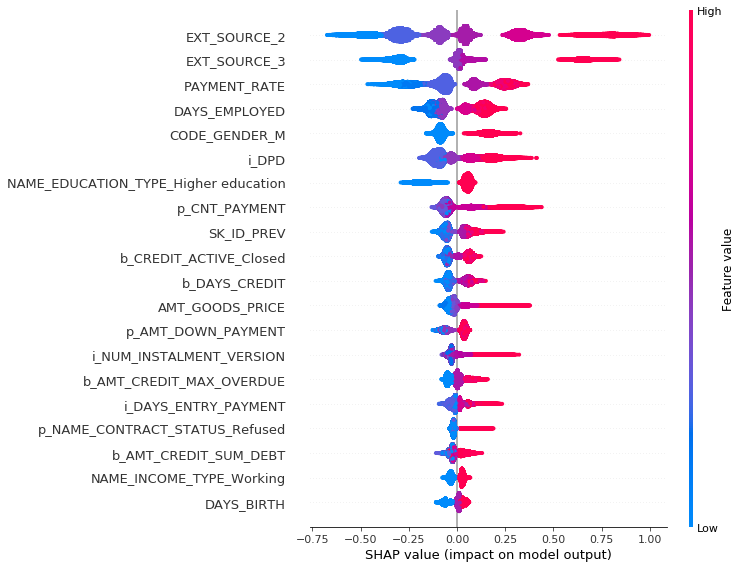

In [54]:
shap.summary_plot(shap_values, train[cols], feature_names=cols, max_display=20)